# Predicting 70s & 80s Funk Album Movement On Billboard Charts
### *by Andy Friedman*
I really like funk and R&B from the 70's and 80's and I have spent a lot of my life digging through crates full of cheap records. That's really all the background there is for this deeply silly project.

I definitely don't think anything here beyond the basic concept would be useful for the modern music industry. Billboard metrics change with the times, and the 70s and 80s were just very different. This is less an exercise in business strategy than a chance to crack myself up by having Luther Vandross and Evelyn "Champagne" King show up in my data.

## One Important Note
Since Billboard charts are numbered backwards, with #1 being the best and #50 being the bottom of the chart, describing movement on the chart can be confusing.

**For this notebook, everything corresponds to absolute direction.**  

Negative movement 'down' the chart is good, while positive movement 'up' the chart is bad.

(So for example,  an album that moves from #6 to #2 has moved four places 'down' the chart, and its movement is -4.)

# Data Acquistion
---
Billboard has a thorough API with [an equally useful, albeit unofficial, Python wrapper](https://github.com/guoguo12/billboard-charts). This made acquiring the chart data rather straightforward. I wrote a suite of functions which automated all of my data collection and feature engineering.

### 'charto'
'charto' takes the name and date of a Billboard chart and, using the Billboard API, returns a chart object. The chart can be printed in full, but also indexed numerically into individual chart entries which, in turn, know their name, album title and chart position.

For the record, Billboard chart 'date' objects are 'YYYY-MM-DD' strings.

In [177]:
import pandas as pd
import numpy as np
import billboard
import datetime as datetime
import warnings
warnings.simplefilter("ignore")

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
    
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams['axes.facecolor'] = '#F0F0F0'
mpl.rcParams['font.family'] = "Arial"
mpl.rcParams['figure.facecolor'] = 'white'


import seaborn as sns
# mpl.rcParams['figure.edgecolor'] = 'white'
plt.style.use('seaborn-pastel')

In [178]:
def charto(chart='r-b-hip-hop-albums', date='1984-01-22'):
    return billboard.ChartData(chart, date)

### 'date_o'
Since the charts are indexed weekly, not every date has an associated chart. The API automatically adjusted any date accordingly, but could be slow. Eventually I just made a big list of chart dates ('all_dates') and wrote this function to do the conversion locally.

In [179]:
all_dates = pd.read_csv('data_safe/all_dates.csv')

def date_o(d, dates='all_dates'):
    for n in dates:
        if n >= d:
            return n

### 'mega_track'
Given 'start' (a date formatted for Billboard), 'delta' (a number of days) and 'end' (a conditional statement about the stop date), 'mega_track' collects data from the charts over the specified time. After pulling the entries from the closest chart to 'start', it advances 'delta' days and continues reading data. 'Start' will automatically convert to a date with a Billboard chart.

'end' is a conditional statement about 'd1' (the internal date variable). So, setting 'end' to 'd1.year < 1980' means 'mega_track' would continue gathering data until it reached 1980. The function accesses the 'R&B and Hip-Hop Albums' chart by default, but will scrape any chart passed as 'chart_name'. Setting the 'track' variable to True turns on print calls within the function that allow progress tracking.

On its first pass, 'mega_track' collects 'artist', 'title', chart 'position' and 'chart_date', then automatically creates the 'key' column: 'artist' and 'title' joined with '-' to make a universal index.

After pulling all the data from the specified range, 'mega_track' adds a feature for the number of 'weeks_on_chart', as well as three lag columns for chart position. 'lag_1' and 'lag_2' track the album's position in the previous chart and the chart before that respectively, while 'next_pos' is where the album will be on the next chart. The null values created by the lag columns are then filled in with '51', a value representing no longer charting.

(While 'delta' can be set while calling the function, it defaults to 7 and charts are assumed to be consecutive.)

Next, 'mega_track' calculates the movement between weeks: 'next_delta' is between the current week and next week, 'delta_1' between last week and the current week, and 'delta_2' between the previous two weeks. (These values are the later week subtracted from the earlier week.)

The function adds 'move' columns will which become the targets for modeling. 'move' is 1 if the album moves next week and 0 if it doesn't. 'move_2' is 'stay' if the album doesn't move, 'down' if the position goes down and 'up' if not. 'move_2n' is a numerical version of 'move_2', replacing 'down', 'stay' and 'up' with -1, 0 and 1 respectively.

Finally, it creates 'debut' and 'year', the first time the album shows up on the charts and the current year for every entry. (These are mostly for future engineering.)

In [180]:
def mega_track(start, delta, end, chart_name='r-b-hip-hop-albums', track=False):
    d1 = datetime.datetime.strptime(start, '%Y-%m-%d')
    dd = datetime.timedelta(days=delta)

    mega = pd.DataFrame(columns=['artist', 'title', 'chart_date', 'position'])

    # while 'end' is true...
    while eval(end):

        # read d0
        d0 = d1.strftime('%Y-%m-%d')
        print(d0)

        chart = charto(chart_name, d0)
        c_dict = {'artist':[],'title':[],'position':[]}
        for c in chart:
            c_dict['artist'].append(c.artist)
            c_dict['title'].append(c.title)
            c_dict['position'].append(c.rank)

        df = pd.DataFrame(c_dict)

        # add 'chart_date' column to 'df' with all entries equal to d0
        df['chart_date'] = chart.date

        # add 'df' to 'mega'
        mega = pd.concat([mega, df])
        d1 += dd

    mega2 = pd.DataFrame(columns=['artist', 'title', 'key', 'chart_date', 'position', 'weeks_on_chart'])

    # add 'weeks' on chart
    mega['key'] = mega[['artist','title']].apply(lambda x: ' - '.join(x), axis=1)
    for k in mega['key'].unique():
        df = mega[mega['key'] == k]
        df = df.reset_index(drop=True).reset_index().rename(columns={'index':'weeks_on_chart'})
        df['lag_1'] = df['position'].shift()
        df['lag_2'] = df['position'].shift(2)
        df['next_pos'] = df['position'].shift(-1)
        df.fillna('51', inplace=True)

        # add 'total_weeks' and 'peak' columns
        df['peak'] = df['position'].min()
        df['total_weeks'] = df['weeks_on_chart'].max()

        mega2 = pd.concat([mega2, df])

    # convert columns to numerical if possible
    for c in mega2.columns:
        try:
            mega2[c] = pd.to_numeric(mega2[c])
        except ValueError:
            continue

    # add 'delta' columns and 'move'
    mega2['next_delta'] = mega2['next_pos'] - mega2['position']
    mega2['delta_1'] = mega2['position'] - mega2['lag_1']
    mega2['delta_2'] = mega2['lag_1'] - mega2['lag_2']
    mega2['move'] = mega2['next_delta'].map(lambda x: 0 if x == 0 else 1)
    mega2['move_2'] = mega2['next_delta'].map(lambda x: 'up' if x > 0 else ('stay' if x == 0 else 'down'))
    mega2['move_2n'] = mega2['move_2'].map(lambda x: 1 if x == 'up' else (0 if x == 'stay' else -1))

    # add 'debut'
    mega3 = pd.DataFrame(columns=mega2.columns)
    for k in mega2['key'].unique():
        if track:
            print(k)
        df = mega2[mega2['key'] == k].sort_values('chart_date')
        df['debut'] = df.head(1)['chart_date'].values[0]
        mega3 = pd.concat([mega3, mega2])
        
    # add 'year'
    mega3['year'] = mega3['chart_date'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').year)

    return mega3.reset_index(drop=True)

### 'album_track'
This function takes the output of 'mega_track' and, for every album, tacks on the peak position and number of weeks on the chart for the last album by that artist. These features are meant to contextualizes the albums while modeling.

In [181]:
def album_track(mt, track=False):
    mt_cull = mt[[
        'key','artist','title','peak','total_weeks','debut']].drop_duplicates().sort_values(['artist','debut'])
    mt2 = pd.DataFrame(columns=['artist'])
    for a in mt_cull['artist'].unique():
        if track:
            print(a)
        df = mt_cull[mt_cull['artist'] == a]
        df['peak_lag'] = df['peak'].shift()
        df['weeks_lag'] = df['total_weeks'].shift()
        mt2 = pd.concat([mt2, df])
    if track:
        print('adding lags')
    mt2['peak_lag'] = mt2['peak_lag'].fillna(51)
    mt2['weeks_lag'] = mt2['weeks_lag'].fillna(0)

    # merge with 'mega_track'
    mt3 = pd.merge(mt, mt2[['key','weeks_lag', 'peak_lag']], on='key')

    # convert columns to numerical if possible
    for c in mt3.columns:
        try:
            mt3[c] = pd.to_numeric(mt3[c])
        except ValueError:
            continue

    return mt3

# Data Exploration
---
My data is the 'R&B and Hip-Hop' charts from 1975 to 1985, although I scraped a wider range than that to give the albums at either end of the window the proper values. (Otherwise my data would say every album charting on 1/1/1975 debuted that week, for example.) When all was said and done, I have 28673 entries for 2020 albums by 691 artists.


In [182]:
# importing a saved version of the data
df = pd.read_csv('data_safe/df_at_for_models_714.csv').drop('Unnamed: 0', axis=1)

As one would expect, distribution of chart positions is uniform.

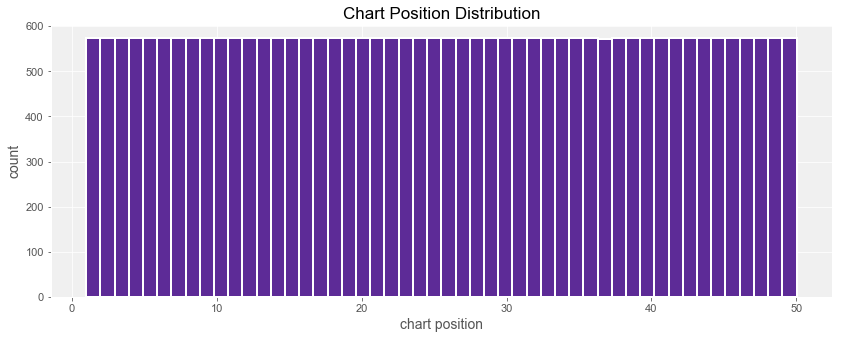

In [183]:
plt.tight_layout()
fig = plt.figure(figsize=(14,5));
# fig.patch.set_facecolor('');
ax = df['position'].hist(ec='w', lw=2, width=1, bins=50, color='#5D2B97');
# ax.set_axis_bgcolor("#F0F0F0")
plt.title(s='Chart Position Distribution', size=17)
plt.xticks(size=11)
plt.yticks(size=11);
plt.xlabel(s='chart position', size=14)
plt.ylabel(s='count', size=14);

# Some Observations About Chart Movement
### Chart position are reasonably predictable.
Every album follows a parabolic path, starting high, descending, stabilizing, then reversing course until they are off the chart.

In [184]:
def chart_path(artist, cols, x, y, i=None):
    if i is None:
        keys = df[df['artist']==artist]['key'].unique()
    else:
        keys = [df[df['artist']==artist]['key'].unique()[x] for x in i]
    plots = len(keys)
    rows = int(plots/cols) + (plots % cols)
    n = 1
    fig = plt.figure(figsize=(x,y))
    fig.patch.set_facecolor('w')
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=.85,
                wspace=None, hspace=0.35)
    for k in keys:
        d = df[df['key'] == k]
        t = d['title'].values[0]
        yr = d['year'].values[0]
        plt.subplot(rows, cols, n)
        ax2 = plt.plot('weeks_on_chart', 'position', color='#5D2B97', data=d, linewidth=2)
        ax1 = plt.scatter('weeks_on_chart', 'position', data=d, color='purple', edgecolor='black')
        plt.title(s=f'{t}, {yr}', size=24)
        plt.xlabel(s='Weeks On Chart', size=12)
        plt.ylabel(s='Chart Position', size=12)
        plt.xticks(size=11)
        plt.yticks(size=11)
        plt.ylim(0,50)
        n += 1

These Al Green albums are good examples of typical chart movement.

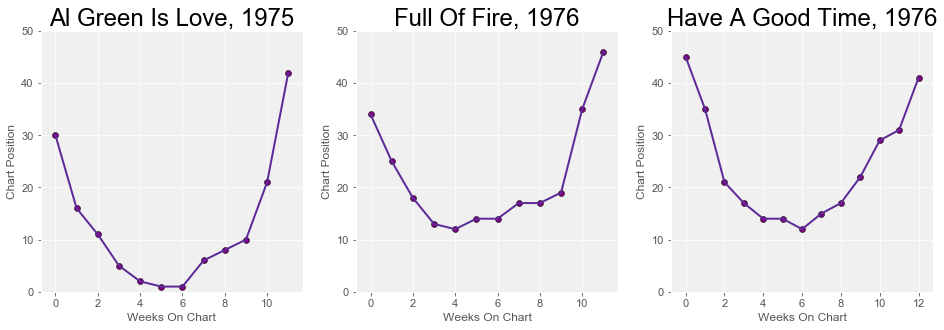

In [201]:
chart_path('Al Green', 3, 16, 5, [2,3,4])

However, the speed at which any of these steps happens is the variable: a highly anticipated album could hit \#1 from the jump and stay there for weeks, while a breakout album slowly gaining traction could take months before it reaches its peak.

For example, Chic's self-titled 1978 debut took 7 weeks to climb from \#45 its peak at \#12. Its took almost 3 more months before it was off the charts. Chic's sophomore album, "C'est Chic", debuted at \#3, hit \#1 the next week and stayed on top of the chart for another 3 months. But even though it was more successful, "C'est Chic" charted for 4 fewer weeks.

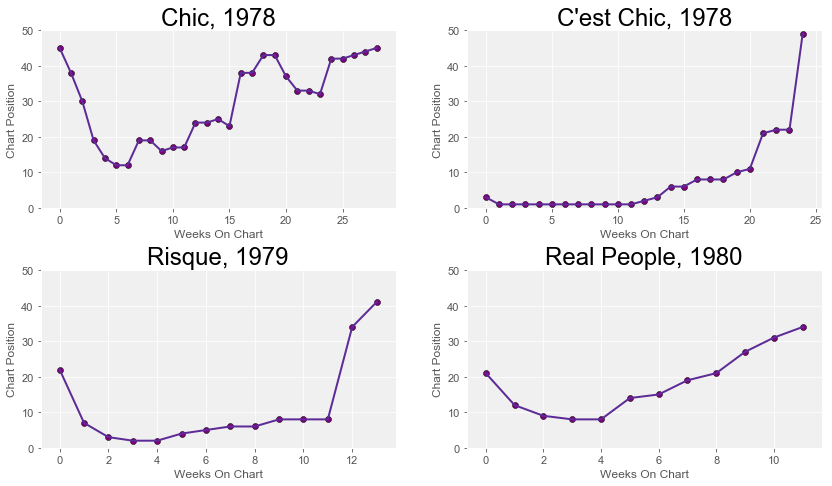

In [185]:
chart_path('Chic', 2, 14, 8, [0,1,2,4])

### Chart Movement Is Slow
It's rare for an album to jump more than a handful of positions from week to week. As shown on the distributions of the three features measuring chart to chart change, the vast majority of the values are below 5.

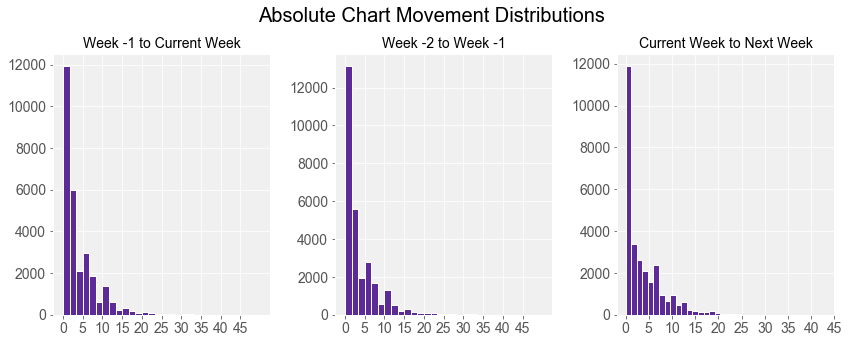

In [187]:
fig = plt.figure(figsize=(14,5))
fig.patch.set_facecolor('white')
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.85,
                wspace=0.3, hspace=None)
plt.suptitle(t='Absolute Chart Movement Distributions',size=20)

# plot 1 
plt.subplot(1,3,1)
abs(df['delta_1']).hist(ec='w', lw=1, bins=30, color='#5D2B97')
plt.title(s='Week -1 to Current Week', size=14)
plt.xticks(np.arange(0,50,5),size=14)
plt.yticks(size=14)


# plot 2
plt.subplot(1,3,2)
abs(df['delta_2']).hist(ec='w', lw=1, bins=30, color='#5D2B97')
plt.title(s='Week -2 to Week -1', size=14)
plt.xticks(np.arange(0,50,5),size=14)
plt.yticks(size=14)

# plot 3
plt.subplot(1,3,3)
abs(df['next_delta']).hist(ec='w', lw=1, bins=30, color='#5D2B97')
plt.title(s='Current Week to Next Week', size=14)
plt.xticks(np.arange(0,50,5),size=14)
plt.yticks(size=14);

### Albums Have Momentum
An album moving in one direction tends to stay moving in that direction. As shown on the plots below, the size and direction of the movement in consecutive weeks are correlated.

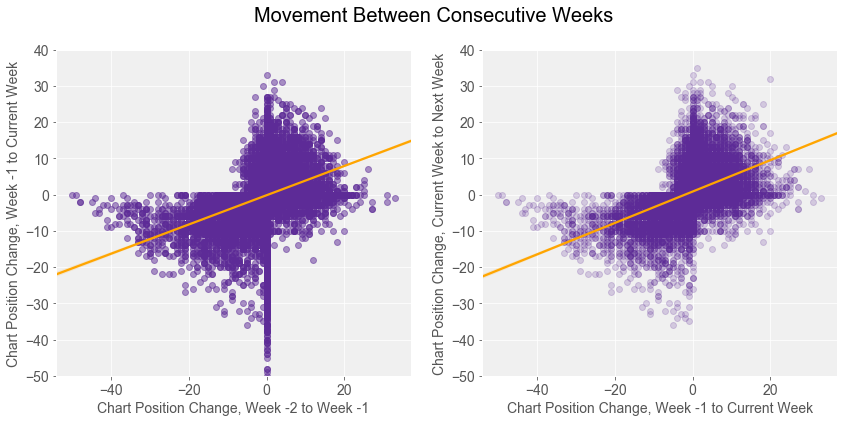

In [188]:
fig = plt.figure(figsize=(14,6))
plt.suptitle(t='Movement Between Consecutive Weeks', size=20)

# plot 1
plt.subplot(1,2,1)
sns.regplot(data=df, x='delta_2', y='delta_1', line_kws={'color':'orange'}, scatter_kws={'color':'#5D2B97','alpha':0.5})

# plt.scatter(data=df, x='delta_2', y='delta_1', alpha=0.2, color='#5D2B97')
# sns.regplot(data=df, x='delta_2', y='delta_1', line_kws={'color':'orange'}, scatter=False)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Chart Position Change, Week -2 to Week -1', size=14)
plt.ylabel(s='Chart Position Change, Week -1 to Current Week', size=14)
plt.ylim(-50,40)

# plot 2
plt.subplot(1,2,2)
sns.regplot(data=df, x='delta_1', y='next_delta', line_kws={'color':'orange'}, scatter_kws={'color':'#5D2B97','alpha':0.2})
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Chart Position Change, Week -1 to Current Week', size=14)
plt.ylabel(s='Chart Position Change, Current Week to Next Week', size=14)
plt.ylim(-50,40);

But while previous movement is a fairly good predictor of where an album will go next, it's not perfect. As shown below, previous movement only predicts next movement about half the time.

In [189]:
move_1 = df['delta_1'].map(lambda x: 'up' if x > 0 else ('stay' if x == 0 else 'down'))
move_2 = df['delta_2'].map(lambda x: 'up' if x > 0 else ('stay' if x == 0 else 'down'))
move_next = df['next_delta'].map(lambda x: 'up' if x > 0 else ('stay' if x == 0 else 'down'))
L = len(df)

print('% Identical Motion from Week -2 to Week -1 and Week -1 to Current Week:')
r1 = (move_1 == move_2).sum()/L
print(r1)
print('')

print('% Identical Motion from Week -1 to Current Week: and Current Week to Next Week')
r2 = (move_1 == move_next).sum()/L
print(r2)
print('')

print('Average % Identical Motion in Consecutive Weeks')
print(np.mean([r1,r2]))
# print('% Identical Motion from Week -1 to Current Week and Current Week to Next Week:')
# print((move_1 == df['move_2']).sum()/L)

% Identical Motion from Week -2 to Week -1 and Week -1 to Current Week:
0.497785372999

% Identical Motion from Week -1 to Current Week: and Current Week to Next Week
0.539880724026

Average % Identical Motion in Consecutive Weeks
0.518833048513


# Features
---

### Weeks on Chart
For example, as an album stays on the charts, it becomes less likely to move, and more likely to move upward if it does move.

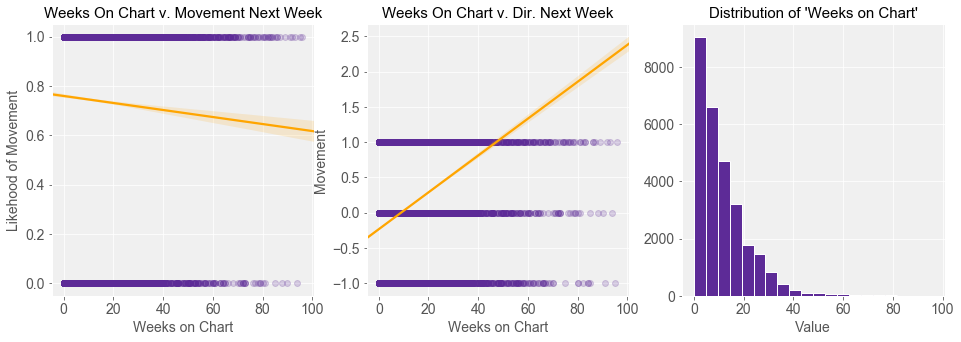

In [200]:
fig = plt.figure(figsize=(16,5))
plt.tight_layout()

# weeks on chart v. movement (binary)
plt.subplot(1,3,1)
sns.regplot(data=df, x='weeks_on_chart', y='move', line_kws={'color':'orange'}, scatter_kws={'color':'#5D2B97','alpha':0.2})
plt.title(s='Weeks On Chart v. Movement Next Week', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Weeks on Chart', size=14)
plt.ylabel(s='Likehood of Movement', size=14)

# weeks on chart v. directional movement
plt.subplot(1,3,2)
sns.regplot(data=df, x='weeks_on_chart', y='move_2n', line_kws={'color':'orange'}, scatter_kws={'color':'#5D2B97','alpha':0.2})
plt.title(s='Weeks On Chart v. Dir. Next Week', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Weeks on Chart', size=14)
plt.ylabel(s='Movement', size=14)

# distribution of weeks on chart
plt.subplot(1,3,3)
df['weeks_on_chart'].hist(ec='w', lw=1, bins=20, color='#5D2B97')
plt.title(s='Distribution of \'Weeks on Chart\'', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Value', size=14);

### Chart Position
While worse-charting albums are more likely to move, it's tough to say which direction they will go.

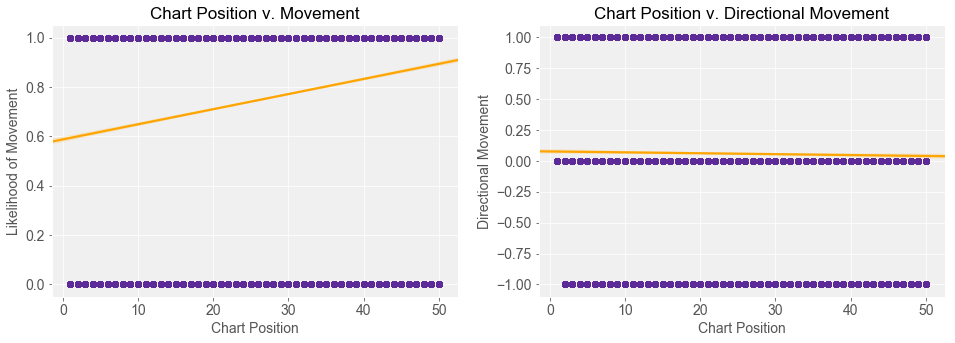

In [191]:
fig = plt.figure(figsize=(16,5))
fig.patch.set_facecolor('w')
plt.tight_layout()

# chart position v. movement
plt.subplot(1,2,1)
sns.regplot(data=df, x='position', y='move', line_kws={'color':'orange'}, scatter_kws={'color':'#5D2B97','alpha':0.2})
plt.title(s='Chart Position v. Movement', size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Chart Position', size=14)
plt.ylabel(s='Likelihood of Movement', size=14)

# chart position v. directional movement
plt.subplot(1,2,2)
sns.regplot(data=df, x='position', y='move_2n', line_kws={'color':'orange'}, scatter_kws={'color':'#5D2B97','alpha':0.2})
plt.title(s='Chart Position v. Directional Movement', size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Chart Position', size=14)
plt.ylabel(s='Directional Movement', size=14);

### Performance of Artist's Last Album
I also included the length of time the artist's last album stayed on the charts and its peak position as a way of contextualizing their popularity.

The longer an artist's last album charted, the less likely it is to move week to week, and slightly more likely to move up.

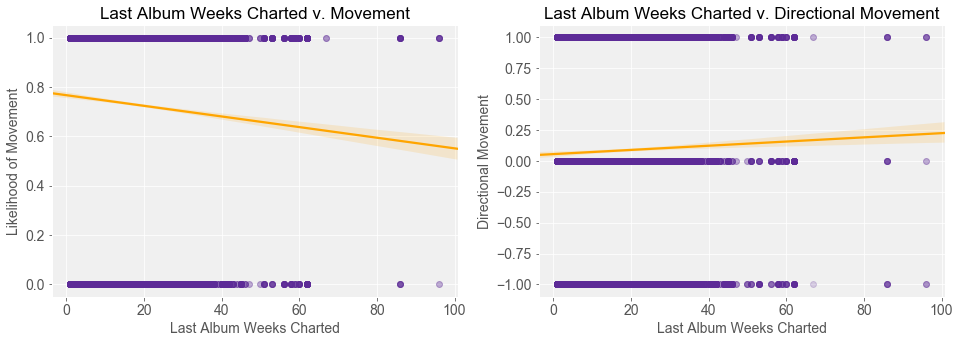

In [192]:
plt.figure(figsize=(16,5))
plt.tight_layout()

# subsetting for artists with a previous album
d = df[df['weeks_lag'] > 0]

# week_lag v. movement
plt.subplot(1,2,1)
sns.regplot(data=d, x='weeks_lag', y='move', line_kws={'color':'orange'}, scatter_kws={'color':'#5D2B97','alpha':0.2})
plt.title(s='Last Album Weeks Charted v. Movement', size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Last Album Weeks Charted', size=14)
plt.ylabel(s='Likelihood of Movement', size=14)

# week_lag v. directional movement
plt.subplot(1,2,2)
sns.regplot(data=d, x='weeks_lag', y='move_2n', line_kws={'color':'orange'}, scatter_kws={'color':'#5D2B97','alpha':0.2})
plt.title(s='Last Album Weeks Charted v. Directional Movement', size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Last Album Weeks Charted', size=14)
plt.ylabel(s='Directional Movement', size=14);

The peak chart position of an artist's last album depresses its chance of movement slightly, and has a mild effect on direction of movement as well.

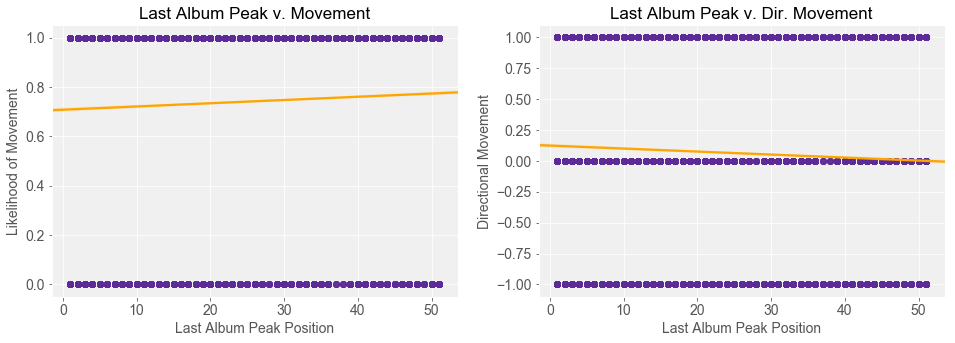

In [193]:
plt.figure(figsize=(16,5))
plt.tight_layout()

# subsetting for artists with a previous album
d = df[df['peak_lag'] != 51]

# peak_lag v. movement
plt.subplot(1,2,1)
sns.regplot(data=df, x='peak_lag', y='move', line_kws={'color':'orange'}, scatter_kws={'color':'#5D2B97','alpha':0.2})
plt.title(s='Last Album Peak v. Movement', size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Last Album Peak Position', size=14)
plt.ylabel(s='Likelihood of Movement', size=14)

# week_lag v. directional movement
plt.subplot(1,2,2)
sns.regplot(data=df, x='peak_lag', y='move_2n', line_kws={'color':'orange'}, scatter_kws={'color':'#5D2B97','alpha':0.2})
plt.title(s='Last Album Peak v. Dir. Movement', size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Last Album Peak Position', size=14)
plt.ylabel(s='Directional Movement', size=14);

# Modeling
---

Models used the following features:

name | data
:---|:---
 **position**| chart position on that date
 **delta_1**| movement between last chart and this chart
 **delta_2**| movement between two charts ago and last chart
 **weeks_on_chart**| how many consecutive weeks the album has charted
 **peak_lag**| peak chart position of artist's previous album
 **weeks_lag**| how many consecutive weeks the artist's previous album charted
 
 Depending on the goal, models used one of these two targets:
 
 name | data
:---|:---
 **move**| binary: 0 for no movement, 1 for movement
 **move_2n**| -1 for downward movement, 0 for no movement, 1 for upward movement

I chose four diverse classification algorithms for my models:
- [Random Forest Classifier (from sci-kit learn)](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [XGBoost Classifier](https://xgboost.readthedocs.io/en/latest/)
- [K-Neighbors Classifier (from sci-kit learn)](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [Stochastic Descent Gradient Classifier with modified Huber loss function (from sci-kit learn)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

Random Forest is a straightforward algorithm that gives a good indication if the data can be modeled. XGBoost is more robust and controls for overfitting. K-Neighbors is non-parametric and thus can sometimes find patterns that elude other models. SGD is careful and conservative.

### Distribution of Target Classes

Category | Frequency In Target Class
:---|:---
 **Up**| 0.400621
 **Down**| 0.342761
 **Stay**| 0.256618

Upward chart movement makes up about 40% of the target class. That is our baseline accuracy for classification.

In [194]:
# import saved scores
scores = pd.read_csv('data_safe/all_scores_diverse_models.csv')

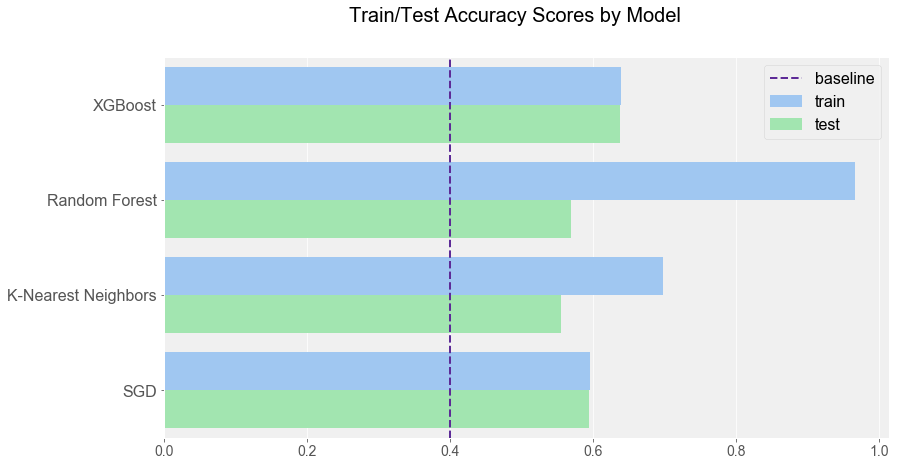

In [195]:
d = scores.loc[0:3].melt(id_vars='model',
                               value_vars=['train','test'],
                               var_name='data',
                               value_name='accuracy').sort_values('data', ascending=False)

fig = plt.figure(figsize=(13,7))
plt.suptitle(t='Train/Test Accuracy Scores by Model', size=20)

sns.barplot(data=d, y='model', x='accuracy', hue='data', ci=None)
plt.axvline(x=0.4, color='#5D2B97', linestyle='--', linewidth=2)
plt.yticks(np.arange(4), ['XGBoost', 'Random Forest', 'K-Nearest Neighbors', 'SGD'], size=16)
plt.xticks(size=14)
plt.xlabel(s='', size=14)
plt.ylabel(s='')
plt.legend(labels=['baseline','train','test'], prop={'size':16});

All four models are more accurate than the baseline. But how well do they predict the individual outcomes?

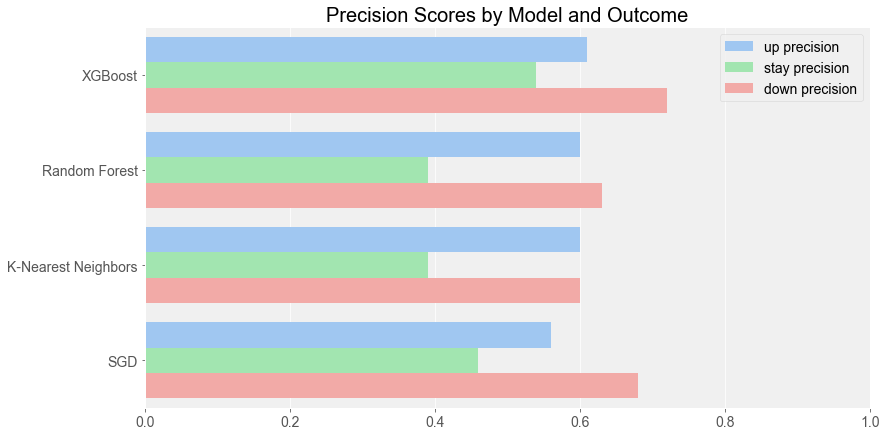

In [203]:
d = scores.loc[0:3].melt(id_vars='model',
                               value_vars=[c for c in scores.columns if 'precision' in c],
                               var_name='metric',
                               value_name='score').sort_values('metric', ascending=False)

fig = plt.figure(figsize=(13,7))
plt.title(s='Precision Scores by Model and Outcome', size=20)

sns.barplot(data=d, y='model', x='score', hue='metric', ci=None)
plt.xticks(size=14)
plt.yticks(np.arange(4), ['XGBoost', 'Random Forest', 'K-Nearest Neighbors', 'SGD'], size=14)
plt.xlabel(s='', size=14)
plt.ylabel(s='')
plt.xlim(0,1)
plt.legend(prop={'size':14});

Rather than predicting all three outcomes at a consistant rate, the models are far better at predicting direction than whether an album will move.

Across all the models, recall for 'stay' (no movement) is substantially lower than for the other two categories. This indicates a lot of false negatives.

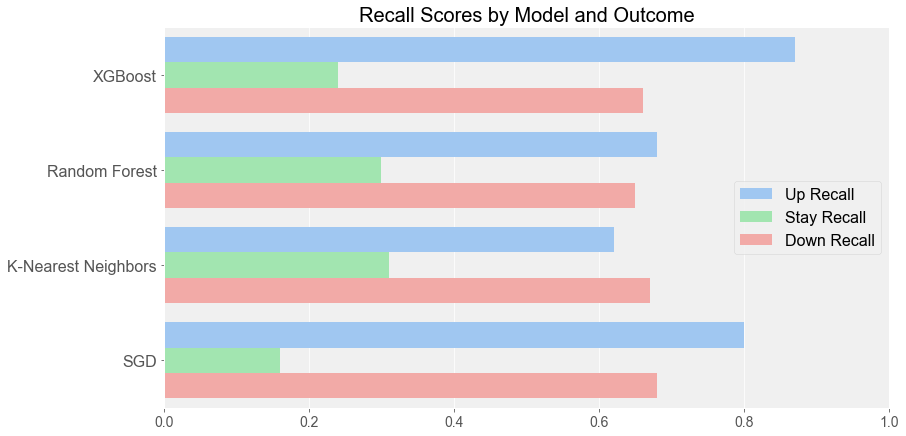

In [204]:
d = scores.loc[0:3].melt(id_vars='model',
                               value_vars=[c for c in scores.columns if 'recall' in c],
                               var_name='metric',
                               value_name='score').sort_values('metric', ascending=False)

fig = plt.figure(figsize=(13,7))
plt.title(s='Recall Scores by Model and Outcome', size=20)

sns.barplot(data=d, y='model', x='score', hue='metric', ci=None)
plt.yticks(np.arange(4), ['XGBoost', 'Random Forest', 'K-Nearest Neighbors', 'SGD'], size=16)
plt.xticks(size=14)
plt.xlabel(s='', size=14)
plt.ylabel(s='')
plt.xlim(0,1)
plt.legend(labels=['Up Recall','Stay Recall','Down Recall'], prop={'size':16});

### Predicting Movement v. Predicting Direction
To verify this trend, here's the same models predicting only whether an album will or will not move.

Since the ratio of 'move' to 'stay' is about 3:1 in the data, I transformed my training set with the [imbalanced learn SMOTE](http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.over_sampling.SMOTE.html) package to simulate a better class balance and (hopefully) get better results. Even so, none of the algorithms beat the baseline accuracy, and all show disappointing recall.

(While SGD does have a high recall for 'stay', it has the lowest values for all other metrics. It's doing something different, but it's still not good.)

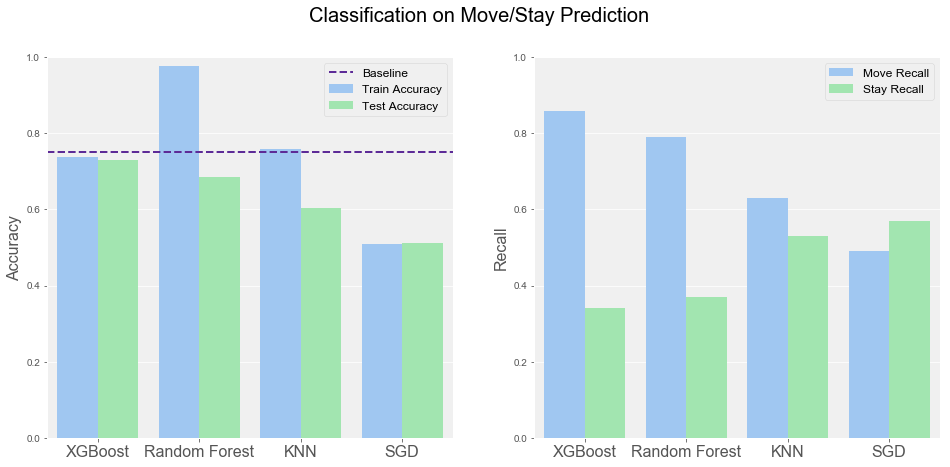

In [206]:
fig = plt.figure(figsize=(16,7))
plt.suptitle(t='Classification on Move/Stay Prediction', size=20)

# accuracy plot
plt.subplot(1,2,1)
d = scores.loc[4:7].melt(id_vars='model',
                               value_vars=['train','test'],
                               var_name='data',
                               value_name='accuracy').sort_values('data', ascending=False)

ax = sns.barplot(data=d, x='model', y='accuracy', hue='data', ci=None)
plt.axhline(y=0.75, color='#5D2B97', linestyle='--', linewidth=2)
plt.xticks(np.arange(4), ['XGBoost', 'Random Forest', 'KNN', 'SGD'], ha='center', size=16)
plt.xlabel(s='')
plt.ylabel(s='Accuracy', size=16)
plt.ylim(0,1)
ax.legend(labels=['Baseline','Train Accuracy','Test Accuracy'], prop={'size':12});

# recall plot
plt.subplot(1,2,2)
d = scores.loc[4:7].melt(id_vars='model',
                               value_vars=['up recall', 'stay recall'],
                               var_name='metric',
                               value_name='score').sort_values('metric', ascending=False)

ax = sns.barplot(data=d, x='model', y='score', hue='metric', ci=None)
plt.xticks(np.arange(4), ['XGBoost', 'Random Forest', 'KNN', 'SGD'], ha='center', size=16)
plt.xlabel(s='')
plt.ylabel(s='Recall', size=16)
plt.ylim(0,1)
ax.legend(labels=['Move Recall','Stay Recall'], prop={'size':12});

On the other hand, the model predicts movement direction fairly well when only given a subset of the data that moves. Accuracy clears baseline and recall scores jump up to around 0.7.

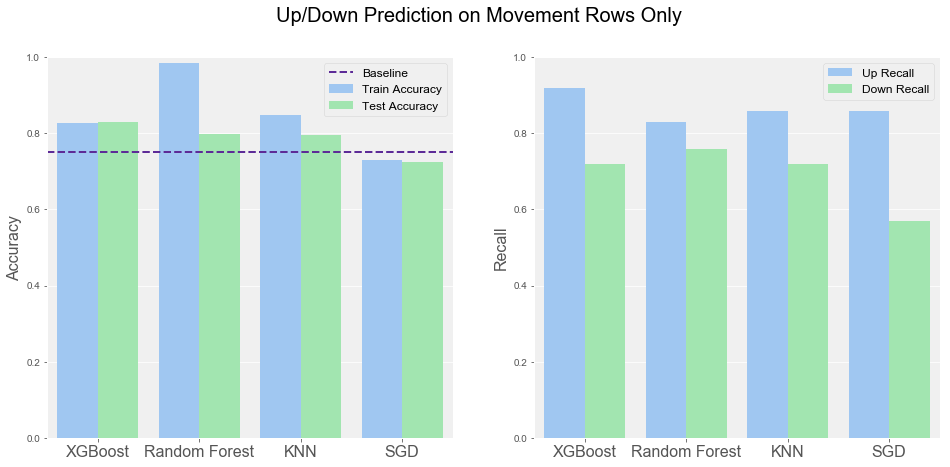

In [205]:
fig = plt.figure(figsize=(16,7))
plt.suptitle(t='Up/Down Prediction on Movement Rows Only', size=20)

plt.subplot(1,2,1)
d = scores.loc[8:11].melt(id_vars='model',
                               value_vars=['train','test'],
                               var_name='data',
                               value_name='accuracy').sort_values('data', ascending=False)

sns.barplot(data=d, x='model', y='accuracy', hue='data', ci=None)
plt.axhline(y=0.75, color='#5D2B97', linestyle='--', linewidth=2)
plt.xticks(np.arange(4), ['XGBoost', 'Random Forest', 'KNN', 'SGD'], ha='center', size=16)
plt.xlabel(s='')
plt.ylabel(s='Accuracy', size=16)
plt.legend(labels=['Baseline','Train Accuracy','Test Accuracy'], prop={'size':12});
plt.ylim(0,1);

plt.subplot(1,2,2)
d = scores.loc[8:11].melt(id_vars='model',
                               value_vars=['up recall', 'down recall'],
                               var_name='metric',
                               value_name='score').sort_values('metric', ascending=False)

sns.barplot(data=d, x='model', y='score', hue='metric', ci=None)
plt.xticks(np.arange(4), ['XGBoost', 'Random Forest', 'KNN', 'SGD'], ha='center', size=16)
plt.xlabel(s='')
plt.ylabel(s='Recall', size=16)
plt.legend(labels=['Up Recall','Down Recall'], prop={'size':12});
plt.ylim(0,1);

# Interpretation
---

### 2 Problems In One
It's clear from the results of these models that I made a fundamental misintreptation of the data. Whether an album's chart position changes from week to week is an entirely different question than which direction it will move if it does.

My model sought to answer two questions at once. Not surprisingly, it answers neither reliably.

### Next Steps
The most obvious way to improve the model would be to add more data, and the easiest way to do so would be to add more lag columns. Given the relative predictability of chart movement, it's reasonable to assume lower chart positions would be more stable, and that this model just lacked the data to make that connection.

A more ambitious approach would be to find more ways to give the model more cultural context. This project started as an attempt to make predictions based solely on album personnel, with the idea that talent might translate into success. This ultimately failed, as did attempts to add personnel-based features to the time series model, but the concept was sound.

Another solution could be to treat this as a regression problem rather than a classification problem. Rather than predicting movement, the model would predict something like momentum: a measure of where an album is tending to go. It would, however, take further work to make this number into an interpretable metric.